# 获取数据


In [2]:
#因为官方将mnist数据集从sklearn基本库中删除 我们需要其他方法
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets' (D:\9_anaconda\lib\site-packages\sklearn\datasets\__init__.py)

In [3]:
#新方法
from sklearn.datasets import fetch_openml
#或者 mnist = fetch_openml('mnist_784', version=1, cache=True） 
mnist = fetch_openml("mnist_784")
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

**Sklearn加载数据集介绍**
+ DESCR 描述数据集
+ data  包含一个数组，每个实例为一行，每个特征为一例
+ target 包含一个带标记的数组

In [4]:
X,y = mnist["data"],mnist["target"]
X.shape,y.shape

((70000, 784), (70000,))

In [5]:
#将数据集转化为array类型
X = X.values
y = y.values

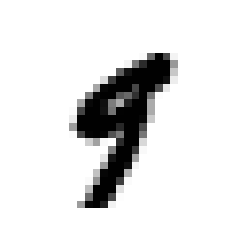

'9'

In [6]:
#可视化数据集
import matplotlib
import matplotlib.pyplot as plt
#选取第36000个数据
some_data = X[36000]
#将some_data改为(28,28)的矩阵
some_digital_data = some_data.reshape(28,28)
plt.imshow(some_digital_data,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

# 划分测试集和训练集

In [7]:
#x--训练集 y--标签
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [8]:
x_train.shape 

(60000, 784)

In [9]:
#对数据进行洗牌：避免数据投入的顺序对网络模型造成影响(增加随机性 增强模型泛化能力)
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train,y_train = x_train[shuffle_index],y_train[shuffle_index]
shuffle_index

array([52643,  8063, 18108, ..., 17446, 33470, 40768])

# 训练一个二分器

## 创建任务目标
二分类学习--5和非5

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
y_train_5,y_train

(array([False, False, False, ...,  True, False, False]),
 ['2', '1', '3', '1', '3', ..., '2', '1', '5', '7', '7']
 Length: 60000
 Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9'])

## 挑选分类器训练
+ SGD(随机梯度下降分类器)
    + 能有效处理大型数据集
    + 适合在线学习 一次一个

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)
sgd_clf.predict([some_data])

array([False])

# 性能考核

## 交叉验证

In [28]:
#自定义交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,
                          random_state=42,shuffle=True)  # StratifiedKFold解释https://blog.csdn.net/cherdw/article/details/54986863
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train_5[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.96605
0.954
0.9656


In [15]:
#调用内置API进行评估
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring="accuracy")

array([0.96375, 0.96635, 0.9705 ])

In [16]:
from sklearn.base import BaseEstimator
class foolEstimator(BaseEstimator):
    def fit(self,x,y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool)
    
fol_es = foolEstimator()
cross_val_score(fol_es,x_train,y_train_5,cv=3,scoring="accuracy")


array([0.9107 , 0.909  , 0.90925])

+ 我们可以发现，较笨的分类器也能有90以上的准确率，这是因为非五的数据在总数据中占比90以上
+ 因为我们需要其他标准来衡量模型好坏

## 混淆矩阵
思路：输出类别A被分类为类别B的次数 eg.5被错分为3的次数

In [18]:
#在训练集上求的预测值
#cross_val_predict返回的是每一折做出的预测值
from sklearn.model_selection import cross_val_predict
y_train_pre = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [20]:
#使用混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pre)

array([[53695,   884],
       [ 1104,  4317]], dtype=int64)

In [39]:
#准确率高--正确的多(儿童动画片)  召回率--假正确的多（错杀一人也可）
#precision_score(y_train_5,y_train_pre)???
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pre),recall_score(y_train_5,y_train_pre)

(0.8300326860219188, 0.7963475373547316)

In [41]:
#只有准确率和召回率都高 才能有较高的F1
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pre)

0.8128412728299754

## 精度\召回率权衡问题

In [49]:
#模型阈值的设定会影响精度、召回率
y_scores = sgd_clf.decision_function(some_data.reshape(1,-1))
y_scores
#报错：ValueError: Expected 2D array, got 1D array instead

array([-5351.6215206])

<module 'matplotlib.pyplot' from 'D:\\9_anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

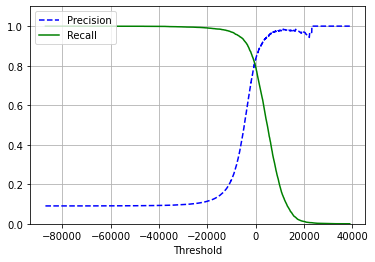

In [51]:
#h获取训练集所有实例的分数
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")
#计算所有阈值的精度和召回值
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#绘制精度和召回值对于阈值的函数图
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1.1])
    
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.grid()
plt

No handles with labels found to put in legend.


<module 'matplotlib.pyplot' from 'D:\\9_anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

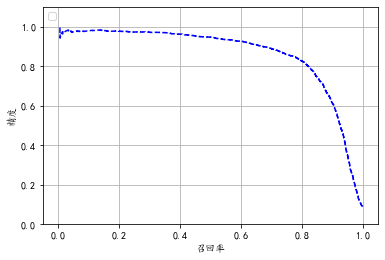

In [55]:
#另一种找到好的权衡就是直接绘制精度和召回率的函数图
def plot_precision_recall_vs_threshold(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b--")
    plt.xlabel("召回率")
    plt.ylabel("精度")
    plt.legend(loc="upper left")
    plt.ylim([0,1.1])

#将字体设置为楷体
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']    
plot_precision_recall_vs_threshold(precisions,recalls)
plt.grid()
plt

#报错：No handles with labels found to put in legend.绘制的时候没有标签

根据上述权衡函数图，我们可以创建任何精度/召回率的分类器

## ROC曲线
绘制真正类率的曲线

<module 'matplotlib.pyplot' from 'D:\\9_anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

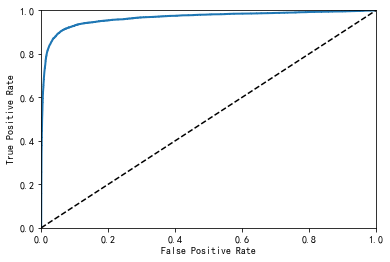

In [56]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr,tpr, linewidth = 2, label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt

**虚线表示纯随机分类器的ROC曲线，优秀的分类器应该离这条线越远越好**

In [57]:
#计算分类器曲线的面积 AUC分数
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9655992493719233

In [62]:
#重新训练随机森林模型
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method = "predict_proba")


In [70]:
y_probas_forest[0:10]

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.91, 0.09],
       [0.99, 0.01],
       [0.92, 0.08],
       [0.97, 0.03],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.87, 0.13],
       [0.93, 0.07]])

<module 'matplotlib.pyplot' from 'D:\\9_anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

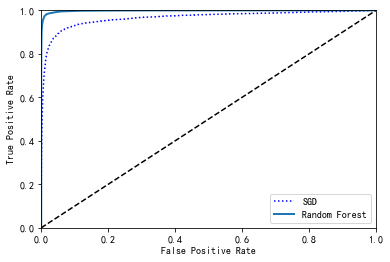

In [65]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,	tpr_forest,	thresholds_forest=roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,"b:",label="SGD") 
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest") 
plt.legend(loc="lower right") 
plt

In [71]:
#随机森林的AUC值
roc_auc_score(y_train_5,y_scores_forest)

ValueError: y should be a 1d array, got an array of shape (60000, 2) instead.

# 多分类器

+ 分类方式
    + 严格二元分类方式：支持向量机(SVM)或者线性分类器
    + 直接处理多类别：随机森林，朴素贝叶斯
    + 几个二元分类器实现多分类
        + 一对多策略(OvA):对于n分类任务，创建n个二分类器，根据分数高低分配分类器
        + 一对一策略(OvO)：一对数字训练一个二元分类器
            + 有点：每个分类器只需要用到部分训练集
            + sklearn可以自动检测到我们使用二分类器进行多分类任务

In [74]:
y_train.shape,x_train.shape

((60000,), (60000, 784))

In [77]:
sgd_clf.fit(x_train,y_train)
sgd_clf.predict([some_data])

array(['9'], dtype='<U1')

从结果我们可以看出，它是进行了多分类，我们也可以通过其他函数进行证明

In [78]:
#你可以调用decision_function()方法。不是返回每个样例的一个数值，而是返回10个数值，一个数值对应于一个类
some_digit_scores = sgd_clf.decision_function([some_data])
some_digit_scores

array([[-30764.25028892, -17423.42677569, -21853.00693309,
         -5085.09622044,   -926.59693799,  -5913.15470043,
        -30204.38871068,  -5777.39865377,  -2365.05902928,
          -589.41089477]])

In [80]:
np.argmax(some_digit_scores)

9

In [81]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [85]:
#如果你想强制Scikit-Learn使用OvO策略或者OvA策略，你可以使用OneVsOneClassifier类
#或者OneVsRestClassifier类。创建一个样例，传递一个二分类器给它的构造函数。
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_data])

array(['4'], dtype=object)

In [86]:
#训练随机森林模型也是很容易的
forest_clf.fit(x_train,y_train)
forest_clf.predict([some_data])

array(['9'], dtype=object)

In [87]:
#我们当然想评估一下这些分类器。像以前一样，想便用交叉验证。让我们用cross_val_score来评估SGDClassifier的精度。
cross_val_score(sgd_clf, x_train, y_train,cv = 3, scoring = "accuracy")

array([0.8912 , 0.8806 , 0.88515])

In [88]:
#输入正则化，得到更高的精度，可以将其精度提高到90%以上
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv = 3, scoring="accuracy")

array([0.89715, 0.89905, 0.90055])

# 误差分析

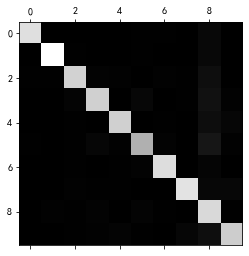

In [91]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)

#画出混淆矩阵图
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

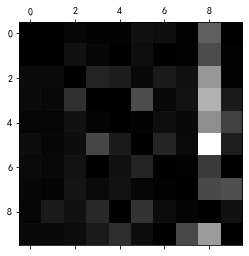

In [92]:
#我们只看其误差图像
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()
#第8列和第9列看起来非常亮  有很多图片错误地分类为8,9--分类
#类别8和类别9行也看起来很亮，说明8,9很容易与其他数字混淆--混淆

**误差分析可以让我们对数据集的某些类别做更加精细的预处理**
**我们可以对某些数据集进行深入研究 探讨差错出现的地方**

# 多标签分类
应用领域：人脸识别

# 多输出分类 